# Neural Network Notebook
Main questions being answered:
1. Can the age of death based on features like gender, occupation, birth year, and associated country be predicted?
2. Can the birth year be predicted based on the same features? (Maybe death as well)
3. Can the mean age of death of a country based on the aggregate data of individuals associated with that country be predicted?
4. Can the life expectancy of a country based on the aggregate data of individuals associated with that country be predicted?
5. How well does the neural network generalize its predictions to countries or occupations that are underrepresented in the dataset?

In [46]:
import pandas as pd
import tensorflow as tf
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Read in the preprocessed age data from the csv file.

In [47]:
data = pd.read_csv('preprocessed_age.csv')

categorical_features = ['Gender', 'Occupation', 'Manner of death', 'Associated Countries']
for cat_val in categorical_features:
    data[cat_val + '_encoded']=pd.factorize(data[cat_val])[0]

# create a boolean mask to filter out rows where the "Associated Country Life Expectancy" column contains more than one value (>3% of dataset)
mask = ~data['Associated Country Life Expectancy'].astype(str).str.contains(',')
filtered_data = data.loc[mask].copy()
filtered_data.loc[:, 'Associated Country Life Expectancy'] = filtered_data['Associated Country Life Expectancy'].str.replace('[', '').str.replace(']', '')
filtered_data['Associated Country Life Expectancy'] = filtered_data['Associated Country Life Expectancy'].astype(float)

# print the filtered DataFrame
filtered_data.head()

,Unnamed: 0,Id,Name,Gender,Occupation,Birth year,Death year,Manner of death,Age of death,Associated Countries,Associated Country Life Expectancy,Gender_encoded,Occupation_encoded,Manner of death_encoded,Associated Countries_encoded
0,1,Q42,douglas adams,male,artist,1952,2001,natural causes,49,united kingdom,81.3,0,0,0,0
1,2,Q91,abraham lincoln,male,politician,1809,1865,homicide,56,united states,78.5,0,1,1,1
2,6,Q272,paul morand,male,artist,1888,1976,NaN,88,france,82.5,0,0,-1,2
3,7,Q296,claude monet,male,artist,1840,1926,natural causes,86,france,82.5,0,0,0,2
4,10,Q303,elvis presley,male,artist,1935,1977,natural causes,42,united states,78.5,0,0,0,1


### Neural Network Implementation #1  
Code for the Neural Network using Keras and Tensorflow.

In [48]:
def run_tensorflow_nn(data, features, target, epochs=100, test_size=0.2, random_state=42):
    # Data Preparation
    X = data[features]
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), X.select_dtypes(include=['int64', 'float64']).columns.tolist()),
            ('cat', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=['object']).columns.tolist())
        ])
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)

    # Convert the preprocessed data to dense format and then to tf.data.Dataset format
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_preprocessed.todense(), y_train)).batch(32)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test_preprocessed.todense(), y_test)).batch(32)

    
    # Define the model
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(1633,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Train the model using tf.data.Dataset format
    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=epochs
    )
    
    # Evaluate the model
    loss, mae = model.evaluate(test_dataset)
    print(f'Mean Absolute Error on test data: {mae}')
    
    # Visualize the training process
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.title('Mean Squared Error vs. Epoch for TensorFlow Implementation') 

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.title('Mean Absolute Error vs. Epoch for TensorFlow Implementation')

    plt.tight_layout()
    plt.show()
    
    return model, history

### Neural Network Implementation #2
Code for the NN using PyTorch.

This is the class for the Torch NN. It includes an initialiser and a forward function. The forward function is where the actual computation is done.

In [49]:
class TorchNN(nn.Module):
    def __init__(self, input_size):
        super(TorchNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [50]:
def run_pytorch_nn(data, features, target, epochs=100, test_size=0.2, random_state=42):
    # Data Preparation
    X = data[features].values
    y = data[target].values.reshape(-1, 1)
    
    # Standardize the Data
    scaler_X = StandardScaler().fit(X)
    scaler_y = StandardScaler().fit(y)
    X_scaled = scaler_X.transform(X)
    y_scaled = scaler_y.transform(y)
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=test_size, random_state=random_state)
    
    # Convert to PyTorch Tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # Create DataLoader objects
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)
    
    # Initialize Model, Loss Function, Optimizer
    model = TorchNN(input_size=X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training Loop
    train_losses = []  # Store training losses for visualization
    for epoch in range(epochs):
        epoch_loss = 0  # Store cumulative loss for each epoch
        for inputs, labels in train_loader:
            # Forward Pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward Pass and Optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Calculate and store average loss for the epoch
        average_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(average_epoch_loss)
        
        # Print Loss
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_epoch_loss:.4f}')
    
    # Model Evaluation
    model.eval()
    test_predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            prediction = model(inputs)
            test_predictions.append(prediction.numpy())
    
    # Convert predictions back to original scale
    test_predictions = scaler_y.inverse_transform(np.array(test_predictions).reshape(-1, 1))

    # Visualizations
    # 1. Training Loss
    plt.plot(train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error Loss')
    plt.title('Training Loss Over Time for Torch Implementation')
    plt.show()
    
    # 2. Predictions vs. Actuals
    plt.scatter(y_test, test_predictions, alpha=0.5)
    plt.xlabel('Actual Age of Death')
    plt.ylabel('Predicted Age of Death')
    plt.title('Predictions vs. Actuals for Torch Implementation')
    plt.show()
    
    return model, test_predictions

### Neural Network Implementation #3
Code for the NN without the usage of any tool kits.

In [51]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.randn(hidden_size, input_size)
        self.b1 = np.zeros((hidden_size, 1))
        self.W2 = np.random.randn(output_size, hidden_size)
        self.b2 = np.zeros((output_size, 1))
        self.orig_min = None
        self.orig_max = None   
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def sigmoid_derivative(self, z):
        return z * (1 - z)

    def forward_propagation(self, X):
        self.Z1 = np.dot(self.W1, X) + self.b1
        self.A1 = self.sigmoid(self.Z1)
        self.Z2 = np.dot(self.W2, self.A1) + self.b2
        self.A2 = self.Z2
        return self.A2

    def compute_loss(self, Y, A2):
        m = Y.shape[1]
        loss = (1/(2*m)) * np.sum((A2 - Y)**2)
        return loss

    def compute_mae(self, Y, A2):
        m = Y.shape[1]
        mae = (1/m) * np.sum(np.abs(A2 - Y))
        return mae

    def compute_rmse(self, Y, A2):
        m = Y.shape[1]
        rmse = np.sqrt((1/m) * np.sum((A2 - Y)**2))
        return rmse

    def compute_r2(self, Y, A2):
        ss_total = np.sum((Y - np.mean(Y))**2)
        ss_res = np.sum((Y - A2)**2)
        r2 = 1 - (ss_res / ss_total)
        return r2

    def backward_propagation(self, X, Y):
        m = X.shape[1]
        
        dZ2 = self.A2 - Y
        dW2 = (1/m) * np.dot(dZ2, self.A1.T)
        db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
        
        dZ1 = np.dot(self.W2.T, dZ2) * self.sigmoid_derivative(self.A1)
        dW1 = (1/m) * np.dot(dZ1, X.T)
        db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
        return dW1, db1, dW2, db2

    def update_parameters(self, dW1, db1, dW2, db2, learning_rate):
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2

    def compute_accuracy(self, Y, A2):
        predictions = (A2 > 0.5)
        accuracy = np.mean(predictions == Y)
        return accuracy
    
    def train(self, X, Y, epochs, learning_rate):
        self.losses = []
        self.maes = []
        self.rmses = []
        self.r2_scores = []
        
        for epoch in range(epochs):
            A2 = self.forward_propagation(X)
            loss = self.compute_loss(Y, A2)
            mae = self.compute_mae(Y, A2)
            rmse = self.compute_rmse(Y, A2)
            r2 = self.compute_r2(Y, A2)
            
            # Store metrics
            self.losses.append(loss)
            self.maes.append(mae)
            self.rmses.append(rmse)
            self.r2_scores.append(r2)
            # if epoch % 10 == 0:
            #     print(f'Epoch {epoch}, Loss: {loss:.6f}, MAE: {mae:.6f}, RMSE: {rmse:.6f}, R2 Score: {r2:.6f}')
            
            dW1, db1, dW2, db2 = self.backward_propagation(X, Y)
            self.update_parameters(dW1, db1, dW2, db2, learning_rate)
        
        self.visualise_training()
    
    def make_predictions(self, X, scaler_Y):
        Y_pred_scaled = self.forward_propagation(X)
        Y_pred_original = scaler_Y.inverse_transform(Y_pred_scaled.T)
        return Y_pred_original
    
    def visualise_training(self):
        plt.figure(figsize=(14, 6))

        plt.subplot(2, 2, 1)
        plt.plot(self.losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Over Time')

        plt.subplot(2, 2, 2)
        plt.plot(self.maes)
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.title('Mean Absolute Error Over Time')

        plt.subplot(2, 2, 3)
        plt.plot(self.rmses)
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.title('Root Mean Squared Error Over Time')
        
        plt.subplot(2, 2, 4)
        plt.plot(self.r2_scores)
        plt.xlabel('Epoch')
        plt.ylabel('R2 Score')
        plt.title('R2 Score Over Time')

        plt.tight_layout()
        plt.show()

    def visualise_predictions(self, Y_actual, Y_pred):
        plt.scatter(Y_actual, Y_pred)
        plt.xlabel("Actual Ages")
        plt.ylabel("Predicted Ages")
        plt.title("Actual vs Predicted Ages of Death")
        
        # Plotting the identity line
        limits = [np.min([plt.xlim(), plt.ylim()]),  # find the min
                np.max([plt.xlim(), plt.ylim()])]  # find the max
        plt.plot(limits, limits, color='black', alpha=0.5, linestyle='--', lw=1)
        
        plt.xlim(limits)
        plt.ylim(limits)
        
        plt.show()

In [52]:
def run_self_nn(features, target, data, hidden_size=5, epochs=100, learning_rate=0.01):
    # Extract features and target from DataFrame
    X_data = data[features].values.T
    Y_data = data[target].values.reshape(1, -1)
    
    input_size = X_data.shape[0]
    output_size = 1
    
    scaler_Y = MinMaxScaler()
    Y_data = scaler_Y.fit_transform(data[target].values.reshape(-1, 1)).reshape(1, -1)
    
    # Initialize neural network
    nn = NeuralNetwork(input_size, hidden_size, output_size)
    
    # Train neural network
    nn.train(X_data, Y_data, epochs, learning_rate)
    
    return nn, scaler_Y

### 1. Can the age of death based on features like gender, occupation, birth year, and associated country be predicted?

##### Using implmentation #1

In [8]:
features = ['Gender_encoded', 'Occupation_encoded', 'Birth year', 'Associated Countries_encoded']
target = 'Age of death'
model_q1_tensorflow, history_q1_tensorflow = run_tensorflow_nn(filtered_data, features, target)

AttributeError: 'numpy.ndarray' object has no attribute 'todense'

##### Using implementation #2

Epoch [10/100], Loss: 0.8402
Epoch [20/100], Loss: 0.8395
Epoch [30/100], Loss: 0.8391
Epoch [40/100], Loss: 0.8382
Epoch [50/100], Loss: 0.8378
Epoch [60/100], Loss: 0.8377
Epoch [70/100], Loss: 0.8374
Epoch [80/100], Loss: 0.8374
Epoch [90/100], Loss: 0.8373
Epoch [100/100], Loss: 0.8372


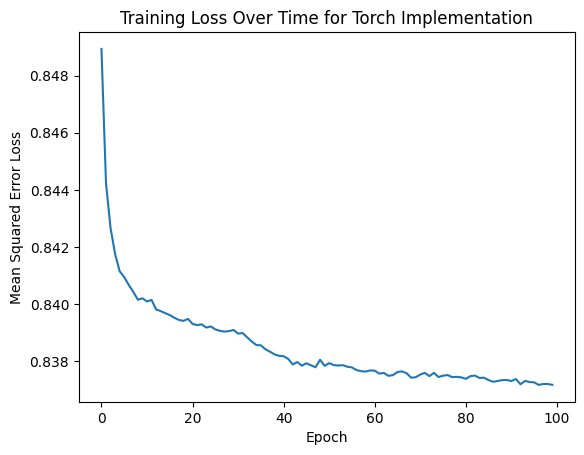

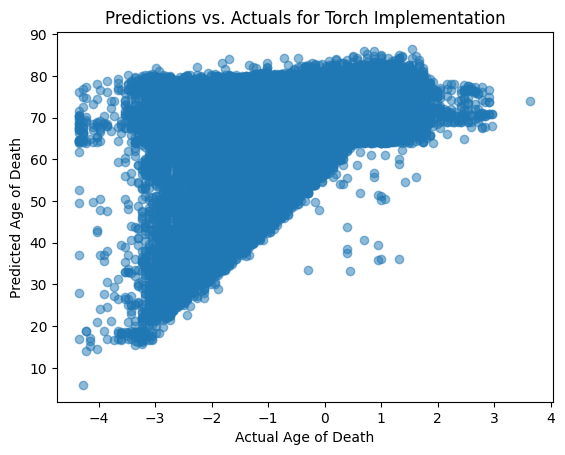

In [103]:
features = ['Gender_encoded', 'Occupation_encoded', 'Birth year', 'Associated Countries_encoded']
target = 'Age of death'

model_q1_torch, predictions_q1_torch = run_pytorch_nn(filtered_data, features, target, epochs=100)

##### Using implementation #3

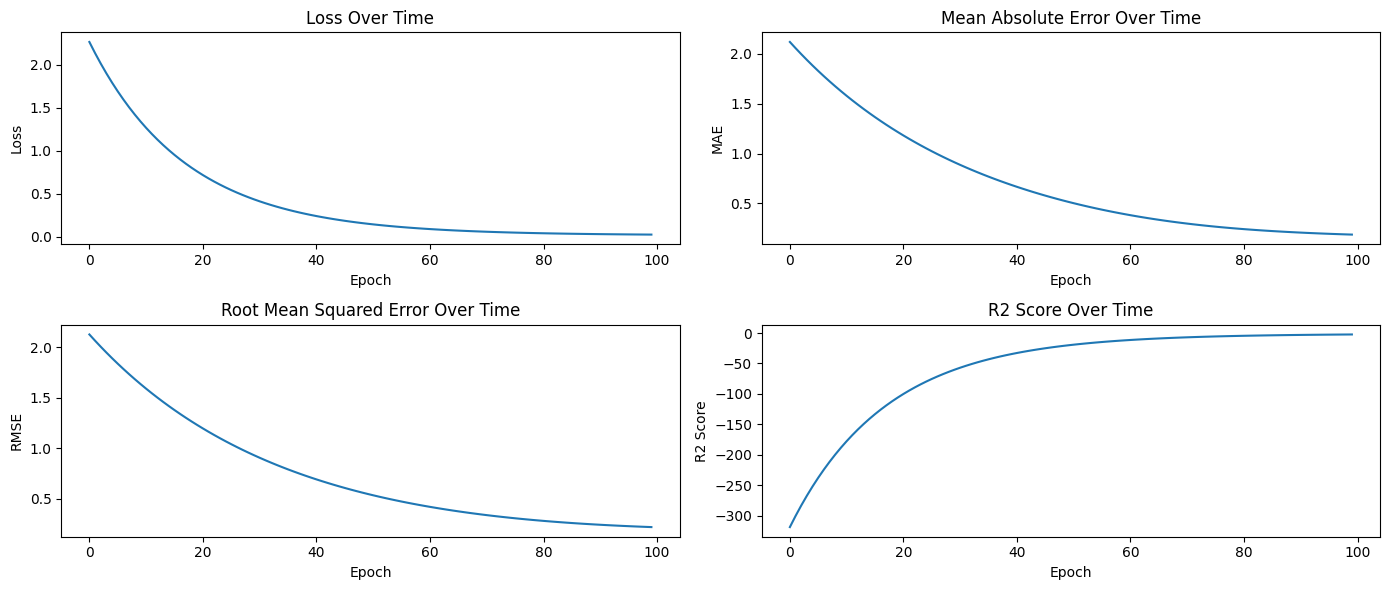

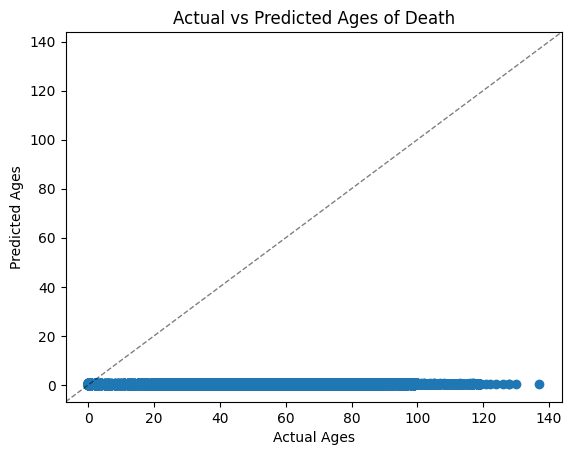

In [143]:
features = ['Gender_encoded', 'Occupation_encoded', 'Birth year', 'Associated Countries_encoded']
target = 'Age of death'

# create a MinMaxScaler object
scaler = MinMaxScaler()
filtered_data[[target + '_norm']] = scaler.fit_transform(filtered_data[[target]])
normalized_target = target + '_norm'

# normalize the categorical values
filtered_data[['Gender_encoded', 'Occupation_encoded', 'Birth year', 'Associated Countries_encoded']] = scaler.fit_transform(filtered_data[['Gender_encoded', 'Occupation_encoded', 'Birth year', 'Associated Countries_encoded']])

trained_nn, scaler_Y = run_self_nn(features, normalized_target, filtered_data)

# Extract features for test data and make predictions using the trained neural network
X_test = filtered_data[features].values.T
Y_pred = trained_nn.make_predictions(X_test, scaler_Y)

# Extract actual Y values and reshape for compatibility with Y_pred then
Y_actual = filtered_data[target].values.reshape(1, -1)

trained_nn.visualise_predictions(Y_actual, Y_pred)

### 2. Can the birth year be predicted based on Gender, Occupation, Death Year, and Country?

##### Using implmentation #1

In [102]:
features = ['Gender_encoded', 'Occupation_encoded', 'Death year', 'Associated Countries_encoded']
target = 'Birth year'
model_q2_tensorflow, history_q2_tensorflow = run_tensorflow_nn(filtered_data, features, target)

AttributeError: 'numpy.ndarray' object has no attribute 'todense'

##### Using implmentation #2

Epoch [10/100], Loss: 0.9391
Epoch [20/100], Loss: 0.9345
Epoch [30/100], Loss: 0.9312
Epoch [40/100], Loss: 0.9272
Epoch [50/100], Loss: 0.9258
Epoch [60/100], Loss: 0.9242
Epoch [70/100], Loss: 0.9230
Epoch [80/100], Loss: 0.9229
Epoch [90/100], Loss: 0.9218
Epoch [100/100], Loss: 0.9161


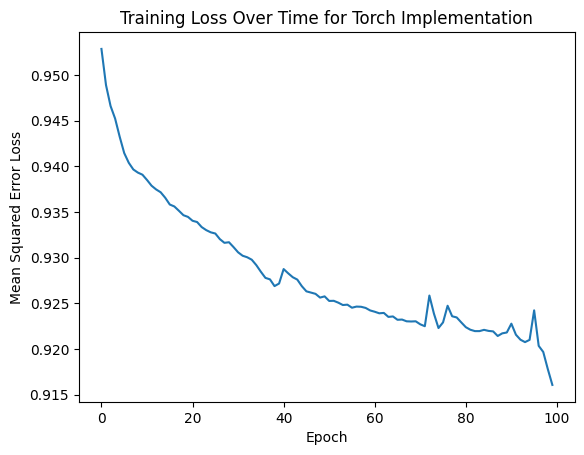

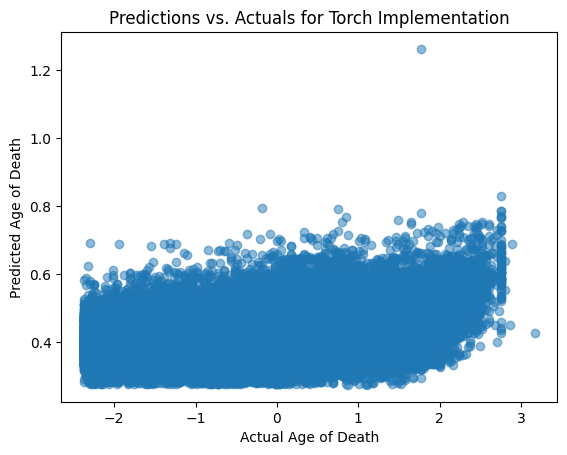

In [105]:
features = ['Gender_encoded', 'Occupation_encoded', 'Age of death', 'Associated Countries_encoded']
target = 'Birth year'

model_q2_torch, predictions_q2 = run_pytorch_nn(filtered_data, features, target, epochs=100)

##### Using implmentation #3

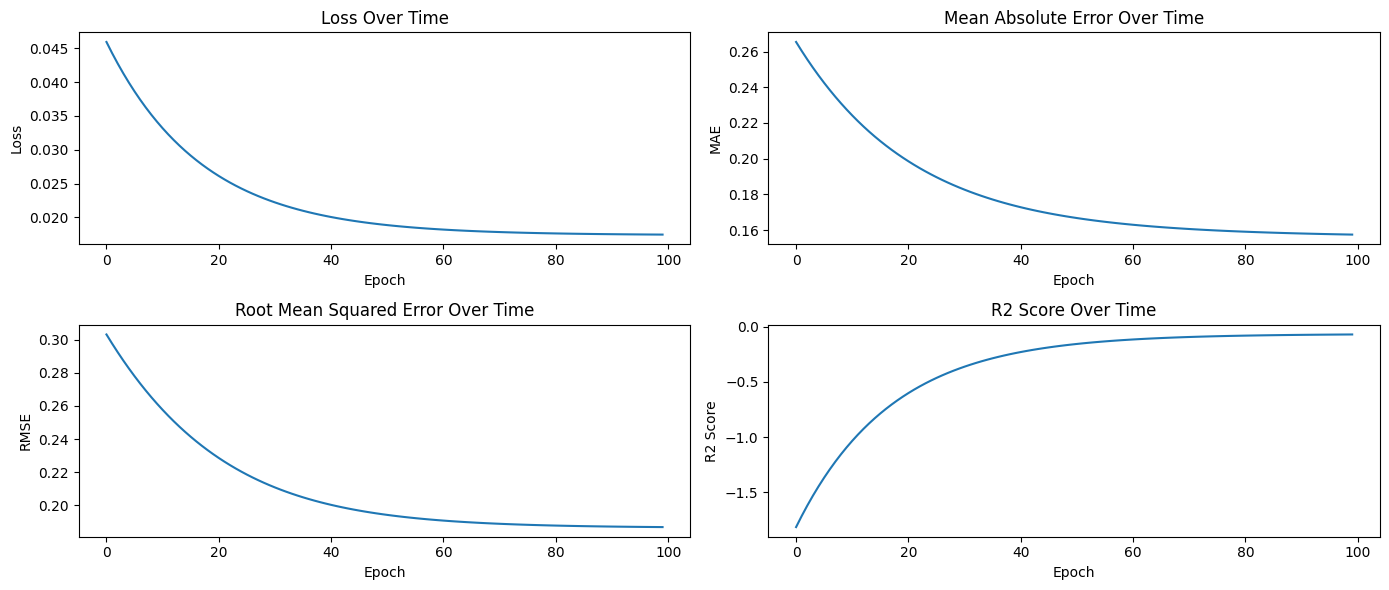

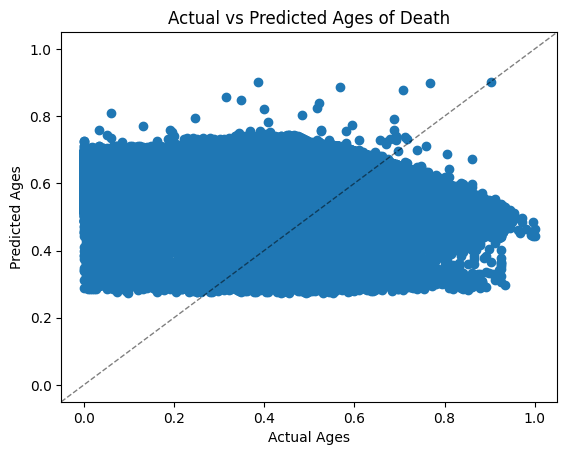

In [44]:
features = ['Gender_encoded', 'Occupation_encoded', 'Age of death', 'Associated Countries_encoded']
target = 'Birth year'

# create a MinMaxScaler object
scaler = MinMaxScaler()
filtered_data[[target + '_norm']] = scaler.fit_transform(filtered_data[[target]])
normalized_target = target + '_norm'

# normalize the categorical values
filtered_data[['Gender_encoded', 'Occupation_encoded', 'Age of death', 'Associated Countries_encoded']] = scaler.fit_transform(filtered_data[['Gender_encoded', 'Occupation_encoded', 'Age of death', 'Associated Countries_encoded']])

trained_nn_q1, scaler_Y = run_self_nn(features, normalized_target, filtered_data)

# Extract features for test data and make predictions using the trained neural network
X_test = filtered_data[features].values.T
Y_pred = trained_nn.make_predictions(X_test, scaler_Y)

# Extract actual Y values and reshape for compatibility with Y_pred then
Y_actual = filtered_data[target].values.reshape(1, -1)

trained_nn.visualise_predictions(Y_actual, Y_pred)

#### 3. Can the age of death be predicted?

##### Using implmentation #1

In [ ]:
features = ['Gender_encoded', 'Occupation_encoded', 'Birth year', 'Associated Countries_encoded']
target = 'Age of death'

model_q3_tensorflow, history_q3 = run_tensorflow_nn(filtered_data, features, target)

##### Using Implementation #2

Epoch [10/100], Loss: 0.8397
Epoch [20/100], Loss: 0.8388
Epoch [30/100], Loss: 0.8385
Epoch [40/100], Loss: 0.8382
Epoch [50/100], Loss: 0.8381
Epoch [60/100], Loss: 0.8378
Epoch [70/100], Loss: 0.8374
Epoch [80/100], Loss: 0.8372
Epoch [90/100], Loss: 0.8372
Epoch [100/100], Loss: 0.8370


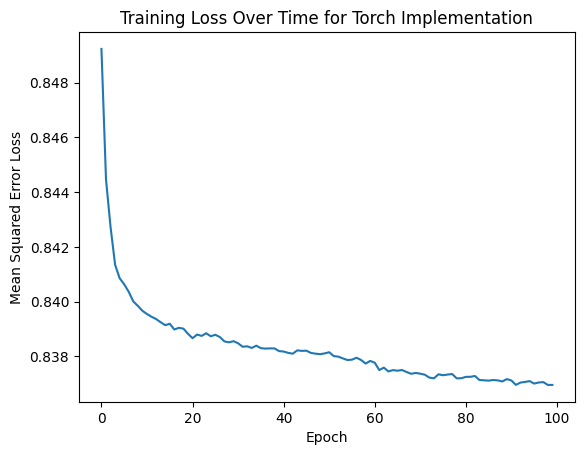

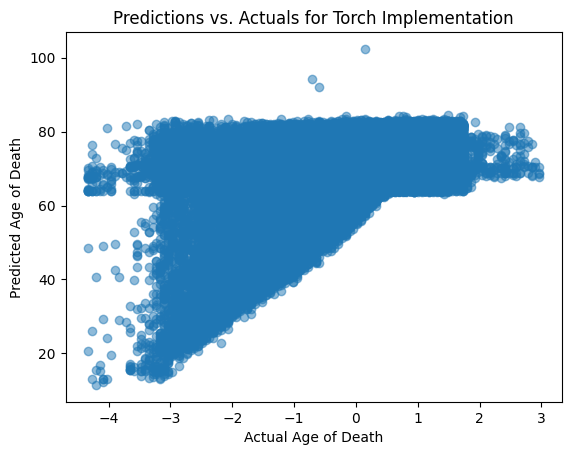

In [40]:
features = ['Gender_encoded', 'Occupation_encoded', 'Birth year', 'Associated Countries_encoded']
target = 'Age of death'

model_q3_torch, predictions_q3 = run_pytorch_nn(filtered_data, features, target)

##### Using Implementation #3

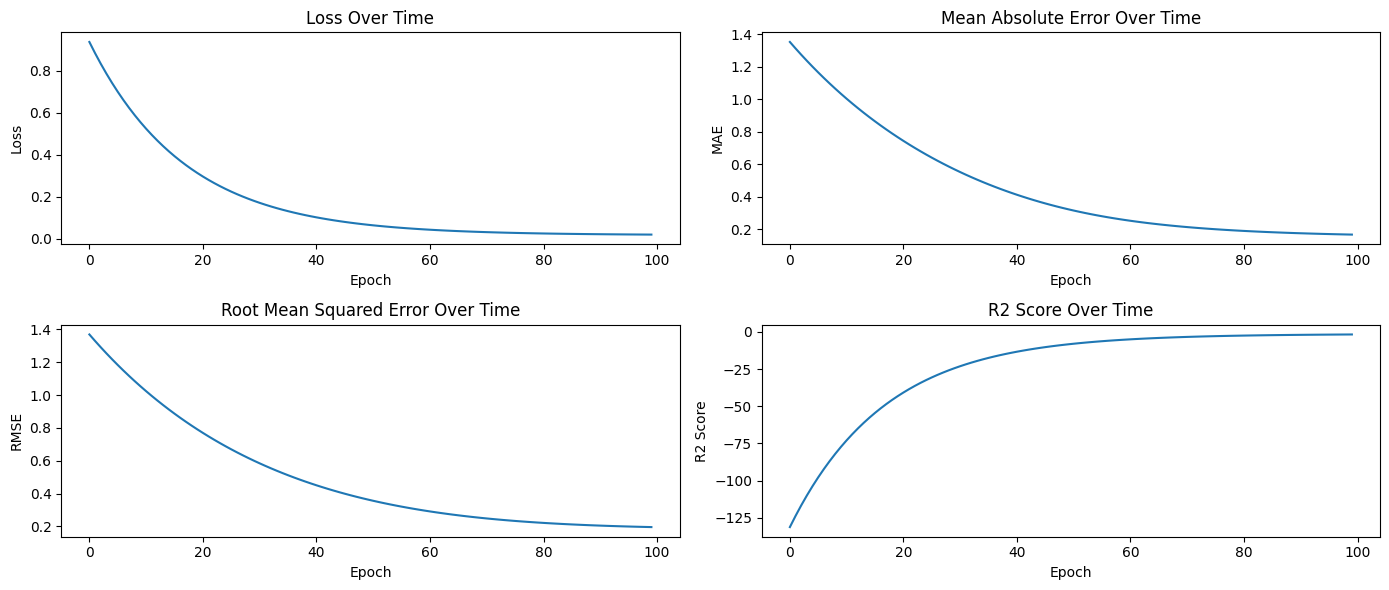

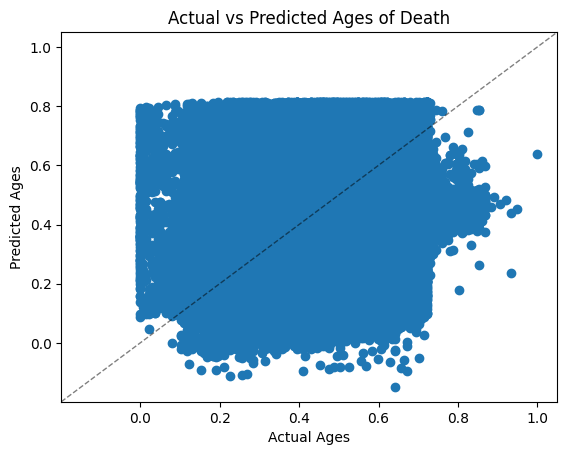

In [45]:
features = ['Gender_encoded', 'Occupation_encoded', 'Birth year', 'Associated Countries_encoded']
target = 'Age of death'

# create a MinMaxScaler object
scaler = MinMaxScaler()
filtered_data[[target + '_norm']] = scaler.fit_transform(filtered_data[[target]])
normalized_target = target + '_norm'

# normalize the categorical values
filtered_data[['Gender_encoded', 'Occupation_encoded', 'Birth year', 'Associated Countries_encoded']] = scaler.fit_transform(filtered_data[['Gender_encoded', 'Occupation_encoded', 'Birth year', 'Associated Countries_encoded']])

trained_nn, scaler_Y = run_self_nn(features, normalized_target, filtered_data)

# Extract features for test data and make predictions using the trained neural network
X_test = filtered_data[features].values.T
Y_pred = trained_nn.make_predictions(X_test, scaler_Y)

# Extract actual Y values and reshape for compatibility with Y_pred then
Y_actual = filtered_data[target].values.reshape(1, -1)

trained_nn.visualise_predictions(Y_actual, Y_pred)

### 4. Can the year of death be predicted?

##### Using implmentation #1

In [ ]:
features = ['Gender_encoded', 'Occupation_encoded', 'Birth year', 'Associated Countries_encoded', 'Associated Country Life Expectancy']
target = 'Death year'

model_q4_tensorflow, history_q4 = run_tensorflow_nn(filtered_data, features, target)

##### Using implmentation #2

Epoch [10/100], Loss: nan
Epoch [20/100], Loss: nan
Epoch [30/100], Loss: nan
Epoch [40/100], Loss: nan
Epoch [50/100], Loss: nan
Epoch [60/100], Loss: nan
Epoch [70/100], Loss: nan
Epoch [80/100], Loss: nan
Epoch [90/100], Loss: nan
Epoch [100/100], Loss: nan


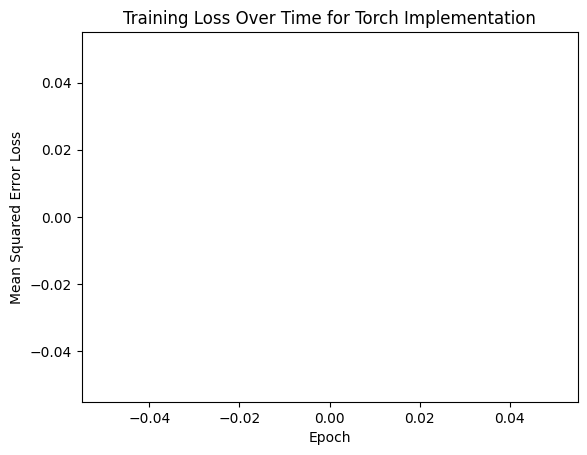

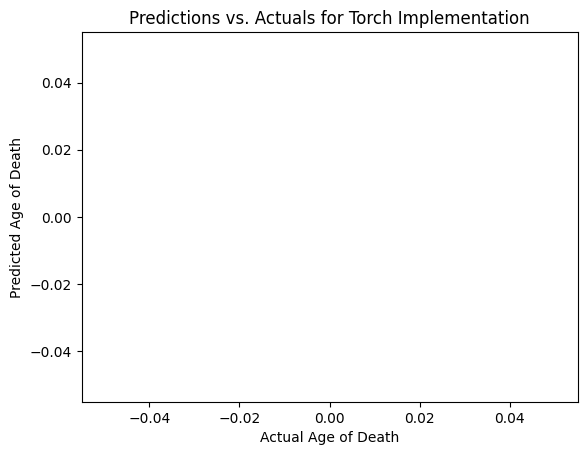

In [53]:
features = ['Gender_encoded', 'Occupation_encoded', 'Birth year', 'Associated Countries_encoded', 'Associated Country Life Expectancy']
target = 'Death year'

model_q4_torch, predictions_q4 = run_pytorch_nn(filtered_data, features, target)

##### Using implmentation #3

In [ ]:
features = ['Gender_encoded', 'Occupation_encoded', 'Birth year', 'Associated Countries_encoded', 'Associated Country Life Expectancy']
target = 'Death year'

# create a MinMaxScaler object
scaler = MinMaxScaler()
filtered_data[[target + '_norm']] = scaler.fit_transform(filtered_data[[target]])
normalized_target = target + '_norm'

# normalize the categorical values
filtered_data[['Gender_encoded', 'Occupation_encoded', 'Birth year', 'Associated Countries_encoded', 'Associated Country Life Expectancy']] = scaler.fit_transform(filtered_data[['Gender_encoded', 'Occupation_encoded', 'Birth year', 'Associated Countries_encoded', 'Associated Country Life Expectancy']])

trained_nn, scaler_Y = run_self_nn(features, normalized_target, filtered_data)

# Extract features for test data and make predictions using the trained neural network
X_test = filtered_data[features].values.T
Y_pred = trained_nn.make_predictions(X_test, scaler_Y)

# Extract actual Y values and reshape for compatibility with Y_pred then
Y_actual = filtered_data[target].values.reshape(1, -1)

trained_nn.visualise_predictions(Y_actual, Y_pred)